### Data preprocessing and preparation for data viz and NLP of Find it Fix It requests to the City of Seattle (from a FOI request)

In [26]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#path for FIFI FOI request
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/FIFI_data_through_5-12-19.xlsx'
path_demogs = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/neighborhood_demogs.xlsx'

In [3]:
#original file has multiple sheets (for different FIFI types)
whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()
for sheet_name in whole_file.sheet_names:
    sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name))
    print(sheet_name)
    print(sheet_data.columns.values)
    sheet_data['FIFI_category'] = [sheet_name]*sheet_data.shape[0]
    combined_data = pd.concat([combined_data, sheet_data], sort=False)

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.head(1)

['Abandoned Vehicle', 'Clogged Storm Drain', 'Community Walk', 'Dead Animal', 'Graffiti Report', 'Litter-Illegal Dumping-Needles', 'Overgrown Vegetation', 'Parking Enforcement', 'Pothole', 'Sign and Signal Maintenance', 'Streetlight Report', 'Other Inquiry']
Abandoned Vehicle
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'License Number' 'State' 'Vehicle Make' 'Vehicle Color'
 'Length of Time Parked' 'Photo']
Clogged Storm Drain
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Location Details.1' 'Causing property damage?' 'Photo']
Community Walk
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Current Issue' 'Location Details.1' 'Photo']
Dead Animal
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Type of animal' 'On private property?' 'Photo']
Graffiti Report
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'D

,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#update FIFI_cat names

combined_data.columns = combined_data.columns.str.replace(' ', '_')

combined_data.rename(columns={'Length_of_Time_Parked': 'Time_parked', 
                       'Causing_property_damage?': 'Property_damage?',
                       'What_is_the_Graffiti_on?': 'Graffiti_location', 
                       'Obscene,_racial,_or_hateful?': 'Obscene/Racial/Hateful?', 
                       'Cross_street_or_intersection?': 'Street/Intersection',
                       'Where_is_the_vegetation_growing': 'Veg_location'}, inplace=True)

combined_data.replace({'Over 1 month': 'Over 1 Month',
                       'Over 3 months': 'Over 3 Months',
                       'Over 3 days': 'Over 3 Days',
                       'Over 1 week': 'Over 1 Week',
                       'Litter-Illegal Dumping-Needles': 'Needles/Dumping', 
                       'Other Inquiry': 'Other',
                       'Clogged Storm Drain': 'Clogged_Drain',
                       'Overgrown Vegetation': 'Vegetation',
                       'Abandoned Vehicle': 'Abnd_Vehicle',
                       'Parking Enforcement': 'Parking',
                       'Graffiti Report': 'Grafitti',
                       'Sign and Signal Maintenance': 'Sign/Signal',
                       'Streetlight Report': 'Streetlight'}, inplace=True)

combined_data['Vehicle_Make'] = combined_data['Vehicle_Make'].str.capitalize()

Combined data shape:  (248884, 38) 

Combined data shape:  (248884, 38) 



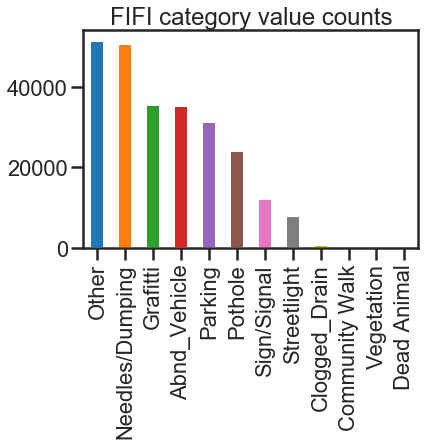

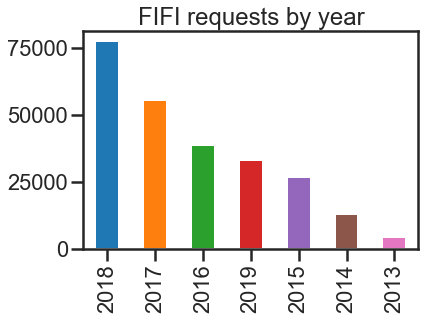

,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,date_bin,zip
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,"(1.3680047394092564e+18, 1.3729967948195128e+18]",WA


In [9]:
#add time related feature columns
print('Combined data shape: ', combined_data.shape, '\n')

#create date column and bins
combined_data['date'] = combined_data['Created_Date'].dt.date
combined_data['year'] = combined_data['Created_Date'].dt.year
combined_data['month'] = combined_data['Created_Date'].dt.month
combined_data['day'] = combined_data['Created_Date'].dt.day
combined_data['day_of_week'] = combined_data['Created_Date'].dt.day_name()
combined_data['day_of_week'] = pd.Categorical(combined_data['day_of_week'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)
combined_data['hour'] = combined_data['Created_Date'].dt.hour

#create study date bins
combined_data['date_bin'] = pd.cut(combined_data['Created_Date'].astype(np.int64), 39)

#drop any rows where location data is not filled in
#combined_data.dropna(subset='Location', axis=0, inplace=True)
combined_data = combined_data[~combined_data['Location'].isnull()]
print('Combined data shape: ', combined_data.shape, '\n')

#create new column with zip code
combined_data['zip'] = combined_data.apply(lambda row: row['Location'].split()[-1], axis=1)   

#viz FIFI requests by category
combined_data['FIFI_category'].value_counts().plot(kind='bar')
plt.title('FIFI category value counts')
plt.show()
print('\n')

#viz FIFI requests by year
combined_data['year'].value_counts().plot(kind='bar')
plt.title('FIFI requests by year')
plt.show()

combined_data.head(1)

In [15]:
#read in excel file containing meta data on zip codes in seattle

#read in pkl file containing 
data_demogs = pd.read_excel(path_demogs)
data_demogs = pd.DataFrame(data = data_demogs)
data_demogs['zip'] = data_demogs['zip'].astype(str)

print('Original data shape:\n', data_demogs.shape, '\n')
print(data_demogs.info())
data_demogs.head()

Original data shape:
 (39, 25) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 25 columns):
zip               39 non-null object
neighborhood      39 non-null object
overdose          32 non-null float64
pop               37 non-null float64
pop_dens          37 non-null float64
housing_units     37 non-null float64
med_home          36 non-null float64
land_area         37 non-null float64
occupied_units    37 non-null float64
occupied_ratio    37 non-null float64
med_income        37 non-null float64
med_age           37 non-null float64
male_%            37 non-null float64
white_%           37 non-null float64
fam_%             37 non-null float64
nokid_%           37 non-null float64
mortgage_%        37 non-null float64
fulltime_%        37 non-null float64
unemploy          37 non-null float64
drive_%           37 non-null float64
publictrans_%     37 non-null float64
other_%           37 non-null float64
wrk_travel        37 non-null 

,zip,neighborhood,overdose,pop,pop_dens,housing_units,med_home,land_area,occupied_units,occupied_ratio,med_income,med_age,male_%,white_%,fam_%,nokid_%,mortgage_%,fulltime_%,unemploy,drive_%,publictrans_%,other_%,wrk_travel,city council,county council
0,98028,Kenmore,NaN,20419.0,3606.0,8566.0,386200.0,5.66,7981.0,0.931707,82448.0,40.0,50.0,79.9,55.0,67.0,53.0,43.0,4.0,80.0,8.2,11.8,35.0,NaN,1.0
1,98031,Kent,NaN,36581.0,4877.0,12846.0,271500.0,7.50,12242.0,0.952981,63709.0,35.0,50.0,52.5,54.0,58.0,51.0,42.0,4.0,86.7,5.8,7.5,25.0,NaN,5.0
2,98057,Renton,NaN,10613.0,1742.0,6049.0,256900.0,6.09,5127.0,0.847578,43339.0,38.0,50.0,51.0,26.0,78.0,19.0,46.0,5.0,79.0,14.0,7.0,25.0,NaN,5.0
3,98101,Dt/FirstH,17.0,10238.0,19718.0,9226.0,420800.0,0.52,7245.0,0.785281,42938.0,42.0,55.0,72.1,14.0,97.0,9.0,44.0,3.0,25.0,20.0,55.0,15.0,7.0,4.0
4,98102,CapitolH/Eastlk,4.0,20756.0,15829.0,14289.0,406000.0,1.31,13032.0,0.912030,65054.0,33.0,54.0,82.5,17.0,94.0,21.0,53.0,4.0,43.3,26.4,30.3,15.0,3.0,2.0


In [22]:
#combine FIFI data with corresponding zip code meta data
data_final = pd.merge(combined_data, data_demogs, on='zip', sort=False)
print(data_final.shape)
data_final.head(1)

(248815, 62)


,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,date_bin,zip,neighborhood,overdose,pop,pop_dens,housing_units,med_home,land_area,occupied_units,occupied_ratio,med_income,med_age,male_%,white_%,fam_%,nokid_%,mortgage_%,fulltime_%,unemploy,drive_%,publictrans_%,other_%,wrk_travel,city council,county council
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,"(1.3680047394092564e+18, 1.3729967948195128e+18]",WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#save full data file
data_final.to_pickle('data_final.pkl')

Prep df for NLP analysis

In [24]:
print(data_final.shape)
#only use entries with a description included
zip_filtered_note = data_final[~data_final['Description'].isna()]
print(zip_filtered_note.shape)

(248815, 62)
(221993, 62)


In [27]:
#use sentiment.vader to get polarity score of each entry
#use original text entry (sentiment vader takes into account puntuation etc)
sid = SentimentIntensityAnalyzer()

zip_filtered_note['polarity'] = [sid.polarity_scores(row)['compound'] for row in zip_filtered_note['Description']]

In [28]:
#remove punctuation, lowercase words
print('removing punctuation and making lowercase')
zip_filtered_note['desc_nltk'] = zip_filtered_note.apply(lambda row: re.sub(r'[^\w\s]','', row['Description']), axis=1)
zip_filtered_note['desc_nltk'] = zip_filtered_note['desc_nltk'].str.lower()

#tokenize each entry
print('tokenizing')
zip_filtered_note['desc_nltk'] = zip_filtered_note.apply(lambda row: word_tokenize(row['desc_nltk']), axis=1)

#remove words with fewer than 3 characters

#remove stop words
print('removing stop words')
stop_words=set(stopwords.words("english"))
zip_filtered_note['desc_nltk'] = [[w for w in row if w not in stop_words] for row in zip_filtered_note['desc_nltk']]

#lemmatize
print('lemmatizing')
lemmatizer = WordNetLemmatizer()
zip_filtered_note['desc_nltk'] = [[lemmatizer.lemmatize(w) for w in row] for row in zip_filtered_note['desc_nltk']]

# Stemming
print('stemming')
ps = PorterStemmer()
zip_filtered_note['desc_nltk'] = [[ps.stem(w) for w in row] for row in zip_filtered_note['desc_nltk']]

#assign a part of speech (POS) to each word
print('assigning POS')
zip_filtered_note['POS'] = [nltk.pos_tag(row) for row in zip_filtered_note['desc_nltk']]

removing punctuation and making lowercase
tokenizing
removing stop words
lemmatizing
stemming
assigning POS


In [29]:
#save NLP prepped file
zip_filtered_note.to_pickle('data_final_nlp.pkl')